In [2]:
import functools
import importlib
import time
from typing import Optional, Sequence, Tuple, Union

from absl import logging
import chex
from ferminet import checkpoint
from ferminet import constants
from ferminet import curvature_tags_and_blocks
from ferminet import envelopes
from ferminet import hamiltonian
from ferminet import loss as qmc_loss_functions
from ferminet.ibc import gaussian
from ferminet.ibc import orbital_200
from ferminet import initial_loss as initial_loss_functions
from ferminet import mcmc
from ferminet import networks
from ferminet import pretrain
#from ferminet import initial_pretrain
from ferminet import energy as comp_loss_functions
from ferminet.utils import multi_host
from ferminet.utils import statistics
from ferminet.utils import system
from ferminet.utils import writers
from ferminet.utils import plotting
from ferminet.utils import curveplot
import jax
import jax.numpy as jnp
import kfac_jax
import ml_collections
import numpy as np
import optax
from typing_extensions import Protocol
import os
import sys

In [208]:
ckpt_path = 'ckpt/stable_env_init/ckpt_init'

In [107]:
filename = 'ckpt/exp_5e-3_m=200/ckpt_init/qmcjax_ckpt_010000.npz'

In [170]:
filename = 'ckpt/ferminet_success.npz'

In [209]:
filename = (checkpoint.find_last_checkpoint(ckpt_path))
t, data, params, opt_state, _ = checkpoint.restore(filename, 256)

In [183]:
t, data_old, params_old, opt_state, _ = checkpoint.restore(filename_old, 256)

In [210]:
a = data[:,:,0:2].reshape(256,2)

In [211]:
params['envelope']

[{'pi': Array([[[0.9981711 , 0.9982601 , 0.9978113 , 0.9992041 , 0.99861753,
           0.998801  , 0.9978721 , 0.99775237, 0.99788433, 0.9978614 ,
           1.0013493 , 0.9981358 , 1.0014533 , 0.9979421 , 0.9988418 ,
           1.000721  ]]], dtype=float32),
  'sigma': Array([[[1.001964  , 1.0018363 , 1.0022144 , 1.0008465 , 1.0016326 ,
           1.0012993 , 1.0021758 , 1.0023264 , 1.0022722 , 1.0021557 ,
           0.9989278 , 1.0019662 , 0.99965256, 1.0021143 , 1.0012379 ,
           0.9993713 ]]], dtype=float32)}]

In [220]:
r_ae = jnp.sqrt(jnp.sum(data**2,axis=2))

In [221]:
r_ae.shape

(1, 256)

In [222]:
sigma = params['envelope'][0]['sigma'][0]
pi = params['envelope'][0]['pi'][0]

In [223]:
f = lambda x: jnp.sum(jnp.exp(-x * sigma) * pi, axis=1)
fvmap = jax.vmap(f, in_axes=1,out_axes=0)

In [224]:
jnp.max(jnp.abs(fvmap(r_ae)))

Array(4.0742617, dtype=float32)

In [225]:
print(fvmap(r_ae).reshape(1,-1))

[[2.07128897e-02 1.65368747e-02 8.23000970e-04 5.12325168e-02
  7.16191530e-03 7.46250033e-01 5.49528934e-03 9.78338122e-02
  3.16433934e-03 3.57088214e-03 2.36355816e-03 9.15792887e-04
  3.23513662e-03 8.40057135e-02 2.70569213e-02 6.25572540e-03
  5.24397612e-01 7.21981144e-03 4.01803628e-02 1.33062955e-02
  2.28022365e-03 2.24060053e-03 1.62540339e-02 1.08449543e-02
  9.15402547e-03 2.89504020e-03 1.31578594e-01 1.66523475e-02
  2.86355126e-03 7.15994276e-03 3.82830352e-02 2.56430544e-03
  1.23406686e-02 3.94078195e-02 7.22240051e-03 1.09648388e-02
  1.06057676e-04 4.33525117e-03 6.58578202e-02 7.88290352e-02
  1.33214772e-01 2.86264241e-01 2.83888429e-01 7.41059426e-03
  3.93366575e-01 2.00905427e-01 3.29133719e-01 4.68635838e-03
  9.16882884e-03 6.46587182e-03 5.00874296e-02 3.31404898e-03
  2.90034758e-03 7.61749735e-03 1.04615934e-01 1.07086459e-02
  3.74722295e-02 3.08939983e-04 2.17029620e-02 1.40069038e-01
  5.01931040e-03 2.68804911e-03 4.40546349e-02 1.81408669e-03
  2.8393

In [226]:
filename

'ckpt/stable_env_init/ckpt_init/qmcjax_ckpt_010000.npz'

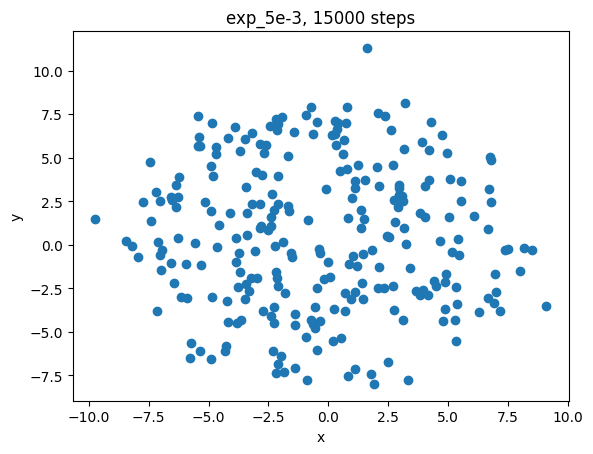

In [227]:
import matplotlib.pyplot as plt
# Calculate the point density
x = a[:,0]
y = a[:,1]

fig, ax = plt.subplots()
plt.scatter(x, y) # c表示标记的颜色
plt.title('exp_5e-3, 15000 steps')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [47]:
from jax.scipy.stats import multivariate_normal
def _i_s(data: jnp.ndarray) -> jnp.ndarray:

        m = 3
        mean = jnp.zeros(m)
        cov = 5 * jnp.eye(m)
        
        pro_dis = multivariate_normal.pdf(data, mean, cov)
        pro_dis_sq = jnp.sqrt(pro_dis)

        return pro_dis_sq

In [64]:
from ferminet import base_config
from ferminet.configs import atom
cfg = atom.get_config()
cfg.system.atom = 'H'
cfg = base_config.resolve(cfg)
cfg.batch_size = 256

In [65]:
    # Device logging
    num_devices = jax.local_device_count()
    num_hosts = jax.device_count() // num_devices
    logging.info('Starting QMC with %i XLA devices per host '
                 'across %i hosts.', num_devices, num_hosts)
    if cfg.batch_size % (num_devices * num_hosts) != 0:
        raise ValueError('Batch size must be divisiaable by number of devices, '
                         f'got batch size {cfg.batch_size} for '
                         f'{num_devices * num_hosts} devices.')
    host_batch_size = cfg.batch_size // num_hosts  # batch size per host
    device_batch_size = host_batch_size // num_devices  # batch size per device
    data_shape = (num_devices, device_batch_size)

    # Check if mol is a pyscf molecule and convert to internal representation
    if cfg.system.pyscf_mol:
        cfg.update(
            system.pyscf_mol_to_internal_representation(cfg.system.pyscf_mol))

    # Convert mol config into array of atomic positions and charges
    atoms = jnp.stack([jnp.array(atom.coords) for atom in cfg.system.molecule])
    charges = jnp.array([atom.charge for atom in cfg.system.molecule])
    nspins = cfg.system.electrons

    if cfg.debug.deterministic:
        seed = 23
    else:
        seed = 1e6 * time.time()
        seed = int(multi_host.broadcast_to_hosts(seed))
    key = jax.random.PRNGKey(seed)

    # Create parameters, network, and vmapped/pmapped derivations

    if cfg.pretrain.method == 'direct_init' or (
            cfg.pretrain.method == 'hf' and cfg.pretrain.iterations > 0):
        hartree_fock = pretrain.get_hf(
            pyscf_mol=cfg.system.get('pyscf_mol'),
            molecule=cfg.system.molecule,
            nspins=nspins,
            restricted=False,
            basis=cfg.pretrain.basis)
        # broadcast the result of PySCF from host 0 to all others hosts
        hartree_fock.mean_field.mo_coeff = tuple([
            multi_host.broadcast_to_hosts(x)
            for x in hartree_fock.mean_field.mo_coeff
        ])

    hf_solution = hartree_fock if cfg.pretrain.method == 'direct_init' else None

    if cfg.network.make_feature_layer_fn:
        feature_layer_module, feature_layer_fn = (
            cfg.network.make_feature_layer_fn.rsplit('.', maxsplit=1))
        feature_layer_module = importlib.import_module(feature_layer_module)
        make_feature_layer = getattr(feature_layer_module, feature_layer_fn)
        feature_layer = make_feature_layer(
            charges,
            cfg.system.electrons,
            cfg.system.ndim,
            **cfg.network.make_feature_layer_kwargs)  # type: networks.FeatureLayer
    else:
        feature_layer = networks.make_ferminet_features(
            charges,
            cfg.system.electrons,
            cfg.system.ndim,
        )

    if cfg.network.make_envelope_fn:
        envelope_module, envelope_fn = (
            cfg.network.make_envelope_fn.rsplit('.', maxsplit=1))
        envelope_module = importlib.import_module(envelope_module)
        make_envelope = getattr(envelope_module, envelope_fn)
        envelope = make_envelope(**cfg.network.make_envelope_kwargs)  # type: envelopes.Envelope
    else:
        envelope = envelopes.make_isotropic_envelope()

    # network构建
    network_init, signed_network, network_options = networks.make_fermi_net(
        atoms,
        nspins,
        charges,
        envelope=envelope,
        feature_layer=feature_layer,
        bias_orbitals=cfg.network.bias_orbitals,
        use_last_layer=cfg.network.use_last_layer,
        hf_solution=hf_solution,
        full_det=cfg.network.full_det,
        ndim=cfg.system.ndim,
        **cfg.network.detnet)

converged SCF energy = -0.47103905418349  <S^2> = 0.75  2S+1 = 2


In [66]:
network = lambda *args, **kwargs: signed_network(*args, **kwargs)[1]  # type: networks.LogFermiNetLike
batch_network = jax.vmap(network, in_axes=(None, 0), out_axes=0)

In [228]:
c = jnp.abs(constants.pmap(batch_network)(params, data) - _i_s(data))

In [229]:
jnp.max(c)

Array(3.4204915, dtype=float32)

In [230]:
d = constants.pmap(batch_network)(params,data)

In [231]:
print(jnp.mean(d))
d

-0.09203547


Array([[ 6.42519910e-03,  3.45455250e-03, -1.38176048e+00,
         3.25906537e-02,  1.86069962e-02,  7.25718439e-02,
         9.67161637e-03, -2.47464757e-02, -5.06544225e-02,
        -6.11551804e-04, -3.37965101e-01, -1.27292275e+00,
        -2.68308688e-02,  4.58969846e-02,  2.11730432e-02,
         1.20846024e-02,  8.43723193e-02,  1.04525266e-02,
         5.92973595e-03,  1.21254716e-02, -3.73975158e-01,
        -3.91924322e-01,  1.14649022e-02,  1.63282920e-02,
         1.23157734e-02, -1.37627080e-01,  2.56921686e-02,
         2.15973165e-02, -1.49753690e-01,  2.18194183e-02,
        -3.36703699e-04, -2.58996874e-01,  6.67864038e-03,
         2.11418811e-02,  4.75656427e-03,  7.17349630e-03,
        -3.42042851e+00,  3.75435799e-02,  1.90975051e-02,
         3.91548797e-02, -2.15760581e-02,  8.75676870e-02,
         5.11962697e-02,  2.16058325e-02,  9.17490497e-02,
         6.95414320e-02,  5.25720008e-02, -5.67577593e-03,
         9.74575616e-03,  1.64522473e-02,  2.27548704e-0

In [122]:
batch_is = jax.vmap(_i_s, in_axes=0, out_axes=0)

In [123]:
batch_is(data)

Array([[0.02262327, 0.0472691 , 0.03237529, 0.06163132, 0.01429678,
        0.03438582, 0.01996008, 0.02114531, 0.03152928, 0.03390354,
        0.01966132, 0.02626262, 0.01394312, 0.02025666, 0.02957783,
        0.05601219, 0.01848237, 0.02242898, 0.03252875, 0.05883812,
        0.01071872, 0.02684108, 0.04115377, 0.03381904, 0.03408651,
        0.03546681, 0.02691009, 0.03691158, 0.01690469, 0.03189737,
        0.06713511, 0.01979998, 0.01991589, 0.02738153, 0.01492883,
        0.05636442, 0.0274658 , 0.02245627, 0.04109124, 0.01963053,
        0.03344945, 0.00966299, 0.04322227, 0.01457078, 0.03649938,
        0.05254999, 0.04390363, 0.0689636 , 0.05995747, 0.0301543 ,
        0.05422073, 0.03298125, 0.01616168, 0.03169559, 0.05738107,
        0.03284768, 0.02129496, 0.04637578, 0.03711573, 0.01962344,
        0.02166166, 0.06282557, 0.02484926, 0.03705048, 0.03602973,
        0.04620858, 0.01391556, 0.02047527, 0.04997971, 0.06526598,
        0.01887653, 0.0589622 , 0.01890506, 0.01